In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import fdrcorrection
import seaborn as sns
from plotnine import *

#### Authors: <br> Jiali Wang (wangjiali0320@gmail.com), John Rouhana, Andrew Hamel, Ayellet Segre (ayellet_segre@meei.harvard.edu)
#### Affiliation: <br> Segre Lab, Ocular Genomics Institute and Department of Ophthalmology, Massachusetts Eye and Ear, Boston, MA 02114, USA
#### Date:<br> Nov. 18, 2021

In [2]:
# path to GWAS enrichment table for all traits, cell types and tissues
enrich_tbl='Supplementary_table_GWAS_enrichment_broad_annnotations.tsv'

# path to differential expression table for broad cell type
sc_df='de_broad.csv'

In [3]:
# read GWAS enrichment table
df_all=pd.read_csv(enrich_tbl,sep='\t')
df_all.head()

,GWAS,Tissue,Cell type,Enrichment p-value,BH adj. Enrichment p-value (tissue-wide),BH adj. Enrichment P-value (Experiment-wide),Fold-enrichment,Fold-enrichment lower 95% CI,Fold-enrichment upper 95% CI,Average GWAS locus set statistic,Fraction of GWAS loci >95% percentile of null loci,Leading edge genes,Num of leading edge genes,Leading edge genes source,Leading edge GWAS loci,Num of leading edge GWAS loci,Relevant tissue
0,Atopic_Dermatitis,Esophagus mucosa,Immune (DC),0.0,0.0,0.0,2.461382,1.759429,3.289772,0.259306,0.225352,"TNFRSF11A;HLA,DRB1;IL7R;ZNF365;REL;BATF3;NFKB1...",33,o;o;eso;o;o;o;eo;eo;o;eso;o;o;so;o;o;o;o;o;so;...,"chr18_62342581_C_T_b38,chr18_62343215_A_C_b38,...",32,skin-Sun_exposed_lower_leg
1,Atopic_Dermatitis,Heart,Immune (NK cell),0.0,0.0,0.0,3.787801,2.640321,5.194365,0.219768,0.205674,FASLG;RUNX3;CD247;ASCL2;CARD11;PRKCQ;TAGAP;IL1...,30,"o;so;o;o;o;eo;o;eso,eo;o;e;o;eo;eso;o;o;o;o;o;...","chr1_172810693_T_C_b38;chr1_24925432_A_T_b38,c...",29,skin-Sun_exposed_lower_leg
2,Atopic_Dermatitis,Heart,Immune (T cell),0.0,0.0,0.0,3.711756,2.589784,5.081587,0.221040,0.205674,IL7R;PRKCQ;CD247;CARD11;FASLG;TAGAP;RUNX3;GATA...,30,"eso;eo;o;o;o;o;so;e;o;o;o;eso,eo;o;o;o;o;o;o;o...","chr5_35881274_G_T_b38,chr5_35852209_G_A_b38,ch...",29,skin-Sun_exposed_lower_leg
3,Atopic_Dermatitis,Esophagus mucosa,Immune (T cell),0.0,0.0,0.0,3.346026,2.444581,4.401951,0.276671,0.253521,CD247;FASLG;IL7R;CARD11;GATA3;PRKCQ;ARHGAP15;T...,37,"o;o;eso;o;e;eo;o;o;eso,eo;o;so;o;o;o;o;eo;o;o;...","chr1_167467033_A_G_b38,chr1_167464183_A_G_b38,...",36,skin-Sun_exposed_lower_leg
4,asthma,Skeletal muscle,Immune (T cell),0.0,0.0,0.0,3.243746,2.107261,4.681709,0.159946,0.169355,IL7R;ITK;RUNX3;PTPRC;ETS1;PRDM1;PYHIN1;TESPA1;...,22,eso;o;so;o;o;o;o;o;o;eo;o;o;eso;o;o;eo;o;o;eo;e;e,"chr5_35874473_C_T_b38,chr5_35852209_G_A_b38,ch...",21,lung


## Heatmap - Figure S18

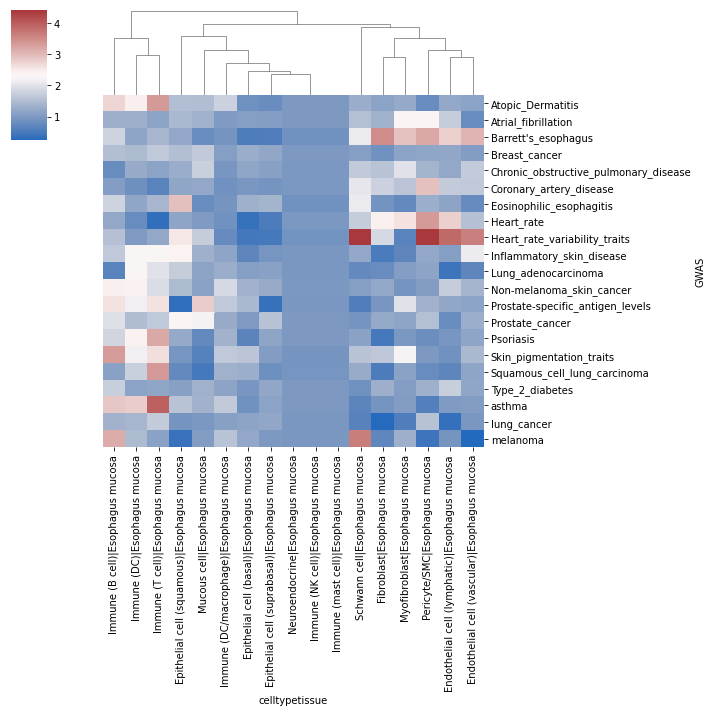

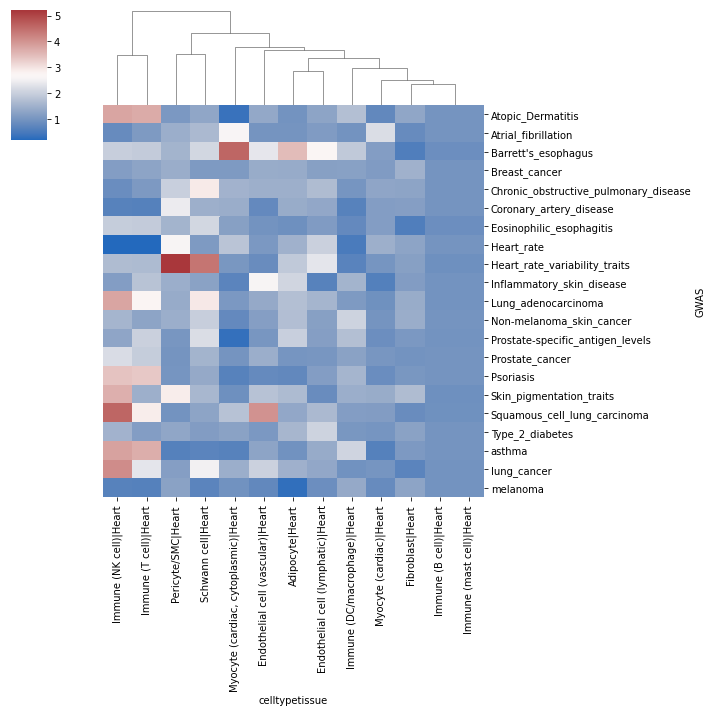

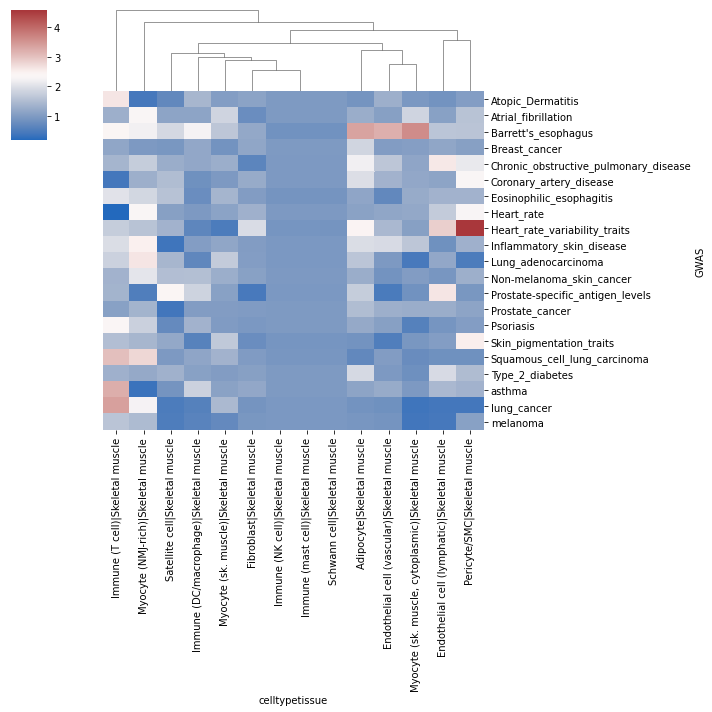

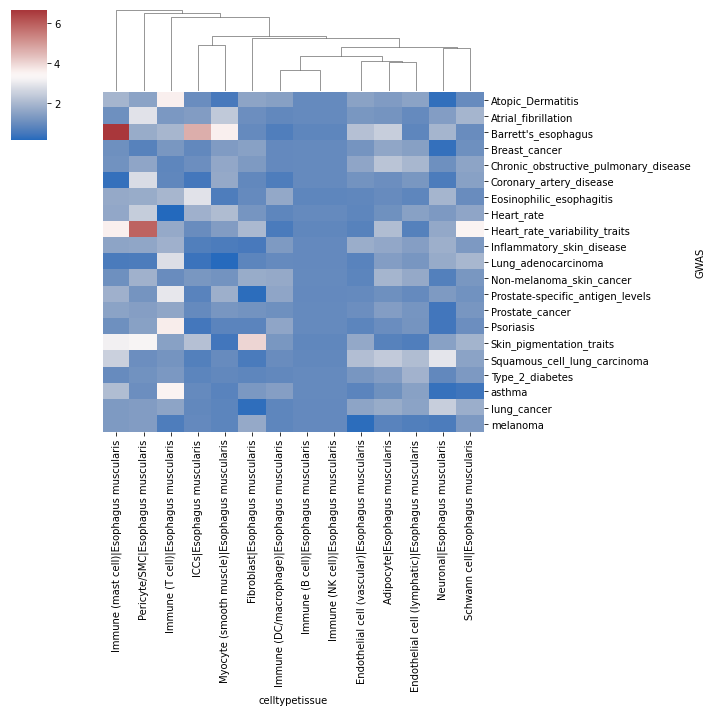

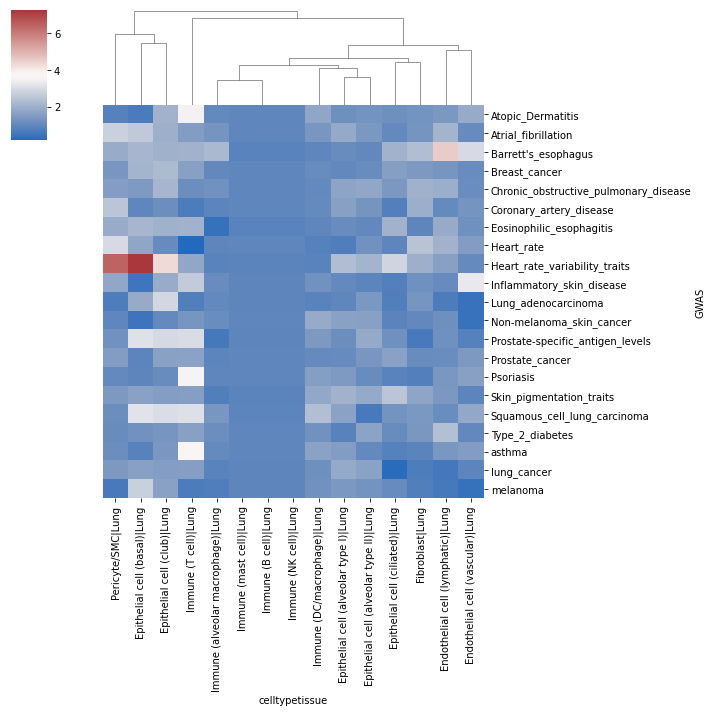

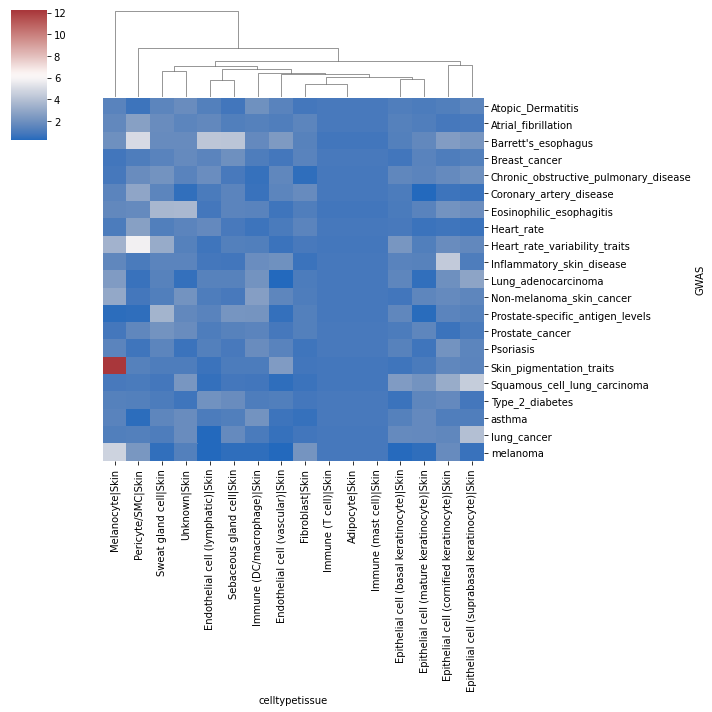

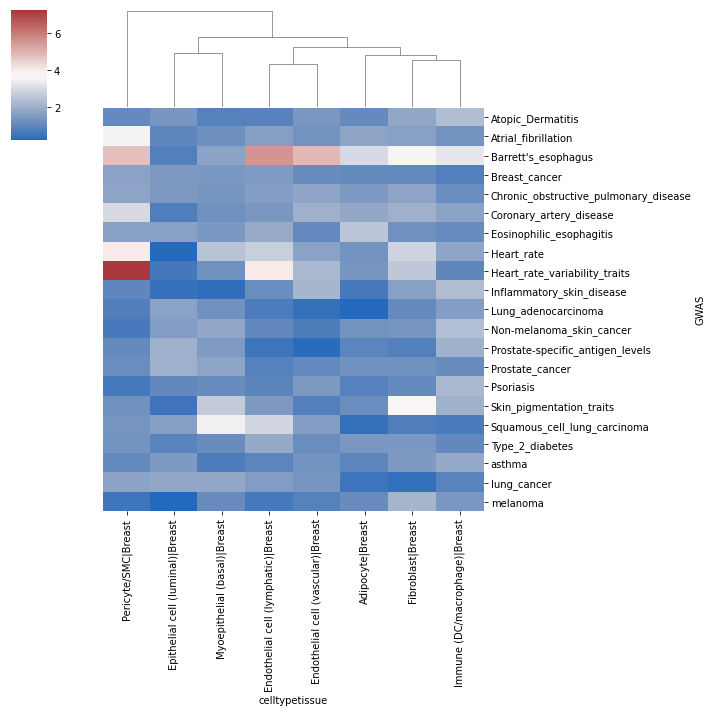

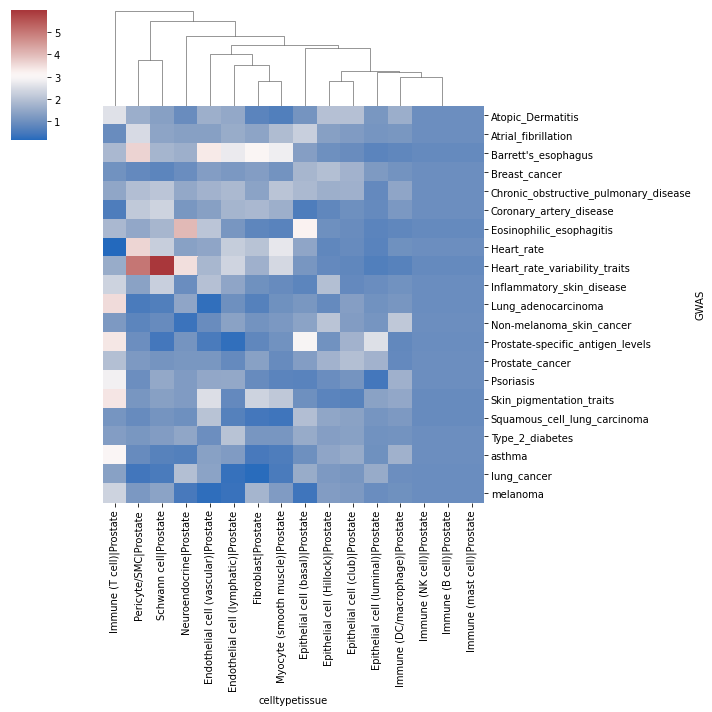

In [4]:
## Order cell type within tissue by hierarchical clustering 
df_all['celltypetissue'] = df_all['Cell type'].astype(str) + '|' + df_all['Tissue'].astype(str)
list_new_orders=[]
for Tissue in df_all['Tissue'].unique():
    df_tissue_bj=df_all.loc[df_all['Tissue']==Tissue]
    df_fr=df_tissue_bj.pivot(index='GWAS', columns='celltypetissue', values='Fold-enrichment')
    g0_tissue = sns.clustermap(df_fr, row_cluster=False, cmap="vlag")
    cell_order=g0_tissue.dendrogram_col.reordered_ind
    list_new_orders+=df_fr.columns[cell_order].tolist()
df_all['celltypetissue']=df_all['celltypetissue'].astype('category').cat.reorder_categories(list_new_orders)

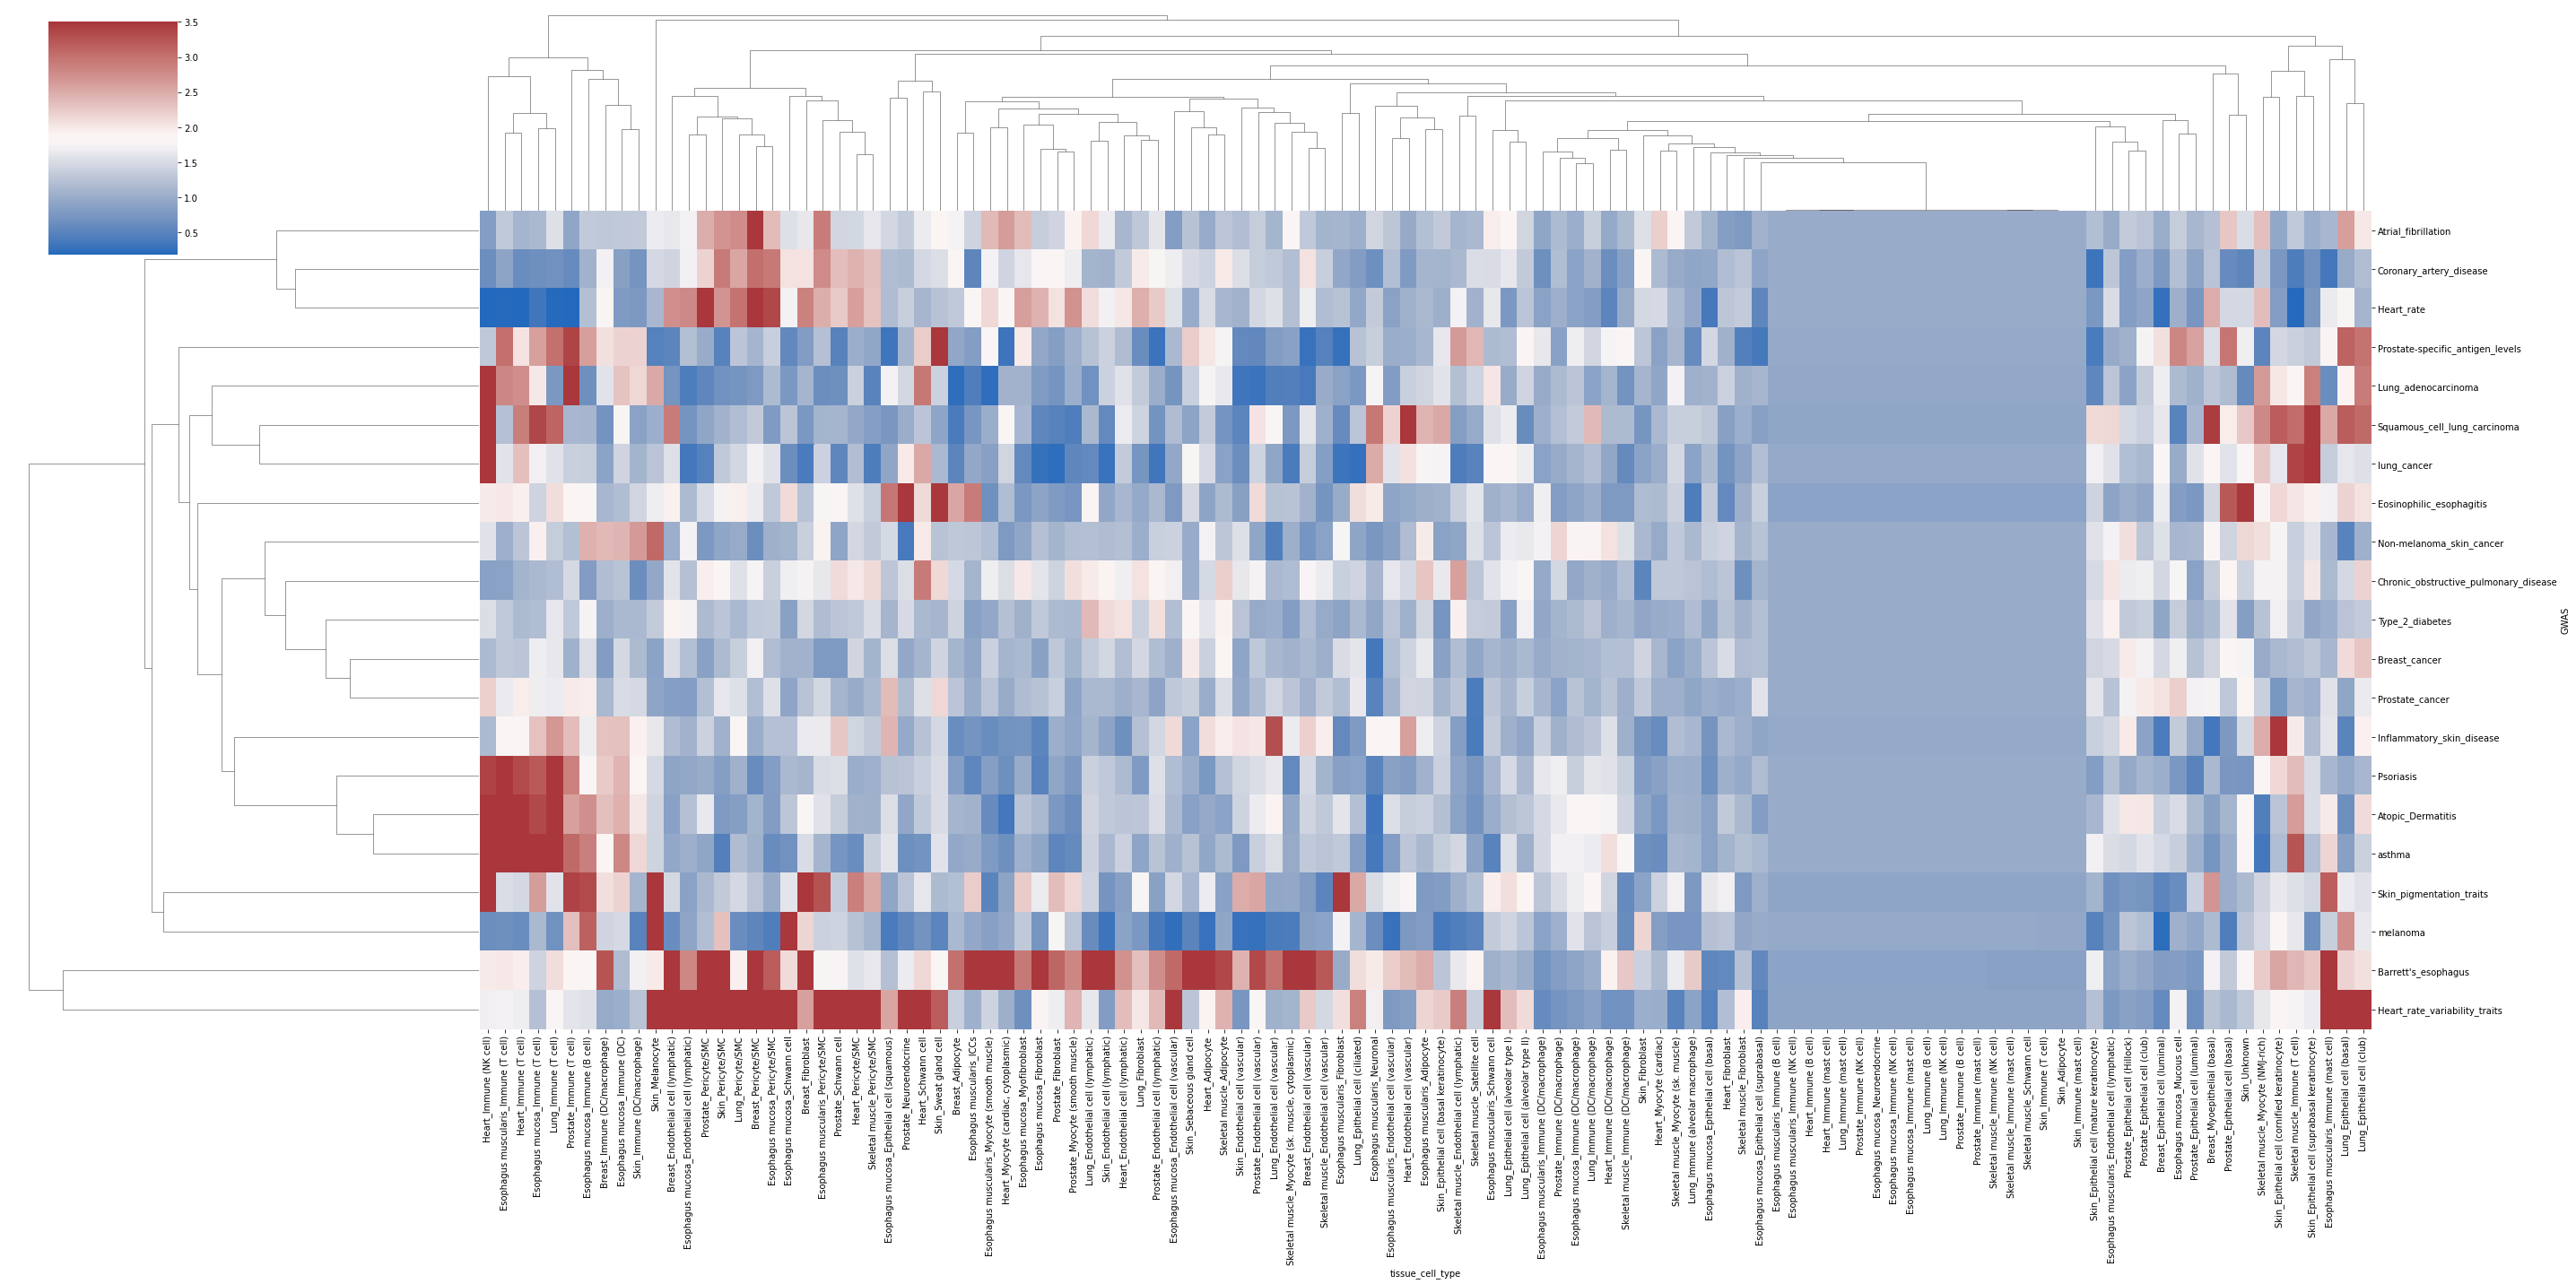

In [5]:
## Order traits by hierarchical clustering
df_all['tissue_cell_type']=df_all['Tissue']+'_'+df_all['Cell type']
df_all_fr=df_all.pivot(index='GWAS', columns='tissue_cell_type', values='Fold-enrichment')
df_all_fr=np.clip(df_all_fr,None, 3.5)
g0 = sns.clustermap(df_all_fr,cmap="vlag",figsize=(40,20))
GWAS_order=df_all_fr.index[g0.dendrogram_row.reordered_ind].tolist()
df_all['GWAS']=df_all['GWAS'].astype('category').cat.reorder_categories(GWAS_order)

In [6]:
## Subset df_all to keep traits and cell types with at least one nomial/tissue-wide significant results
df_sub=df_all.copy()

In [7]:
# keep traits and cell types that have at least one p-value less than 0.05
# p_val_column='Enrichment p-value'  ##nominal 
p_val_column='BH adj. Enrichment p-value (tissue-wide)'  ##tissue-wide

keep_GWAS=df_all[['GWAS',p_val_column]].groupby(['GWAS']).min()[p_val_column]<0.05
df_sub=df_all.loc[keep_GWAS.loc[df_all['GWAS']].values]

keep_tissue_cell=df_sub[['celltypetissue',p_val_column]].groupby(['celltypetissue']).min()[p_val_column]<0.05
df_sub=df_sub.loc[keep_tissue_cell.loc[df_sub['celltypetissue']].values]

In [8]:
# prepare data for heatmap 
df_sub_fr=df_sub.pivot(index='GWAS', columns='tissue_cell_type', values='Fold-enrichment')
df_sub_fr=np.clip(df_sub_fr,None, 3.5)  ## Fold enrichment capped  at 3.5 
df_sub_p=df_sub.pivot(index='GWAS', columns='tissue_cell_type', values='Enrichment p-value')
df_sub_p=(df_sub_p<0.05).replace({0:"",1:"*"}).astype('str')

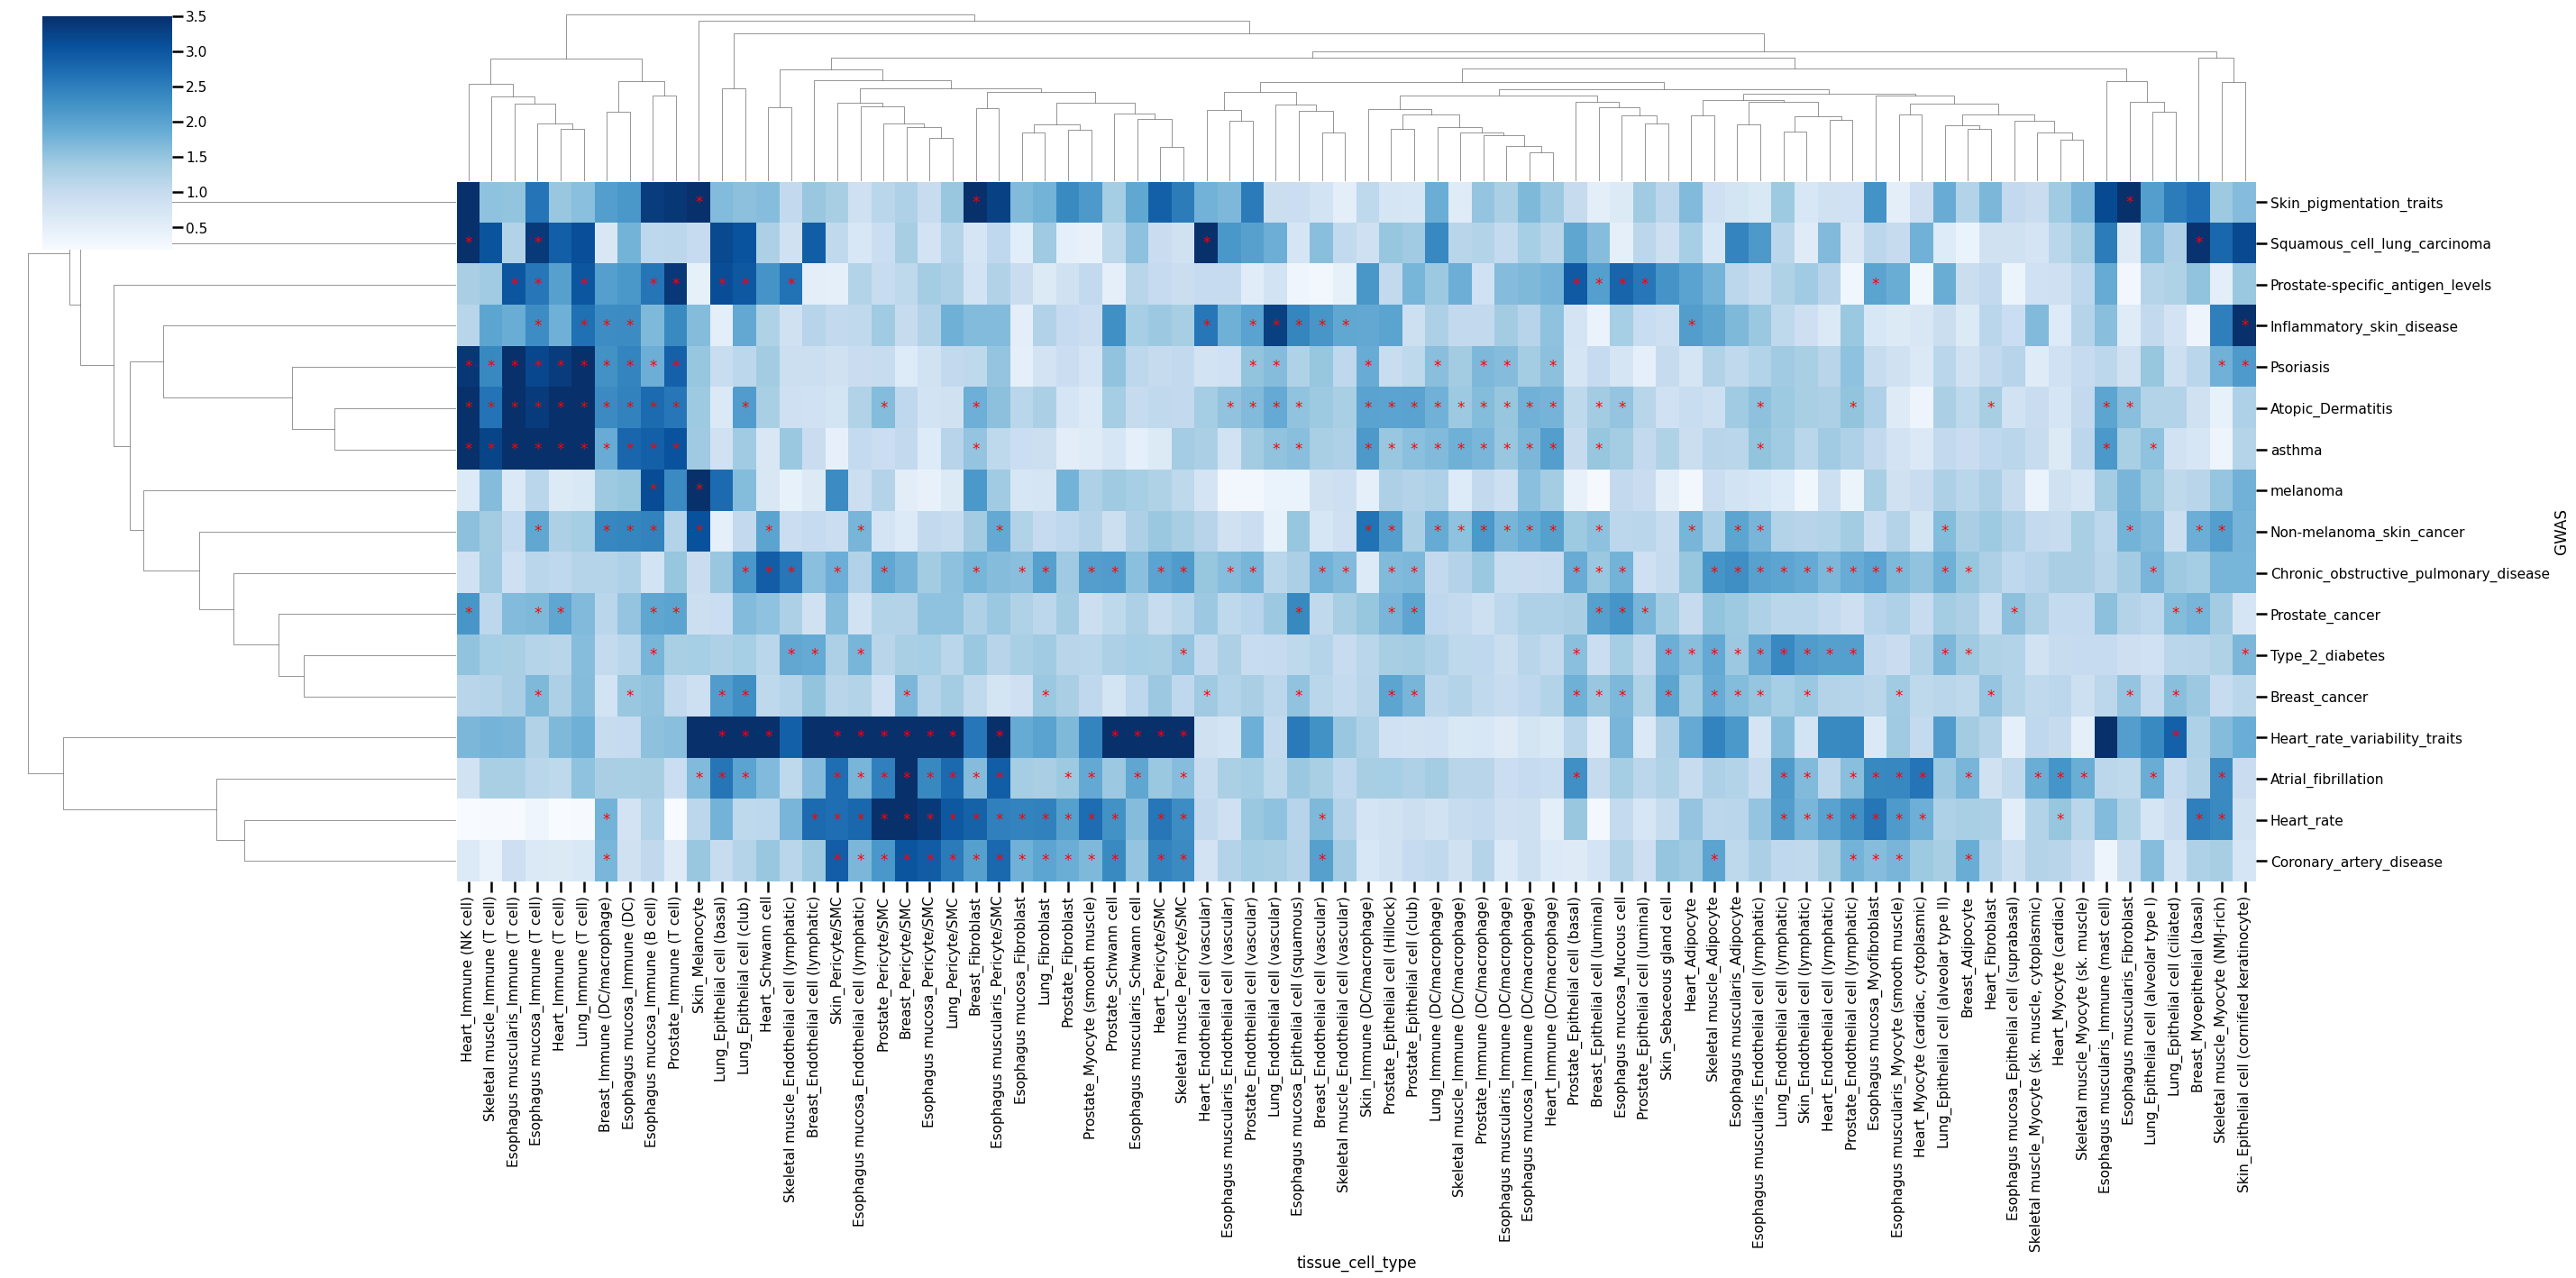

In [9]:
sns.set_context("poster",font_scale=0.7)
g1 = sns.clustermap(df_sub_fr,cmap="Blues",figsize=(40,20),annot=df_sub_p\
                    ,fmt='s',annot_kws={"color": 'red'})
plt.savefig('Fig_S18_heatmap.png',bbox_inches='tight')

## Bubble map -  Figure 5 (B)

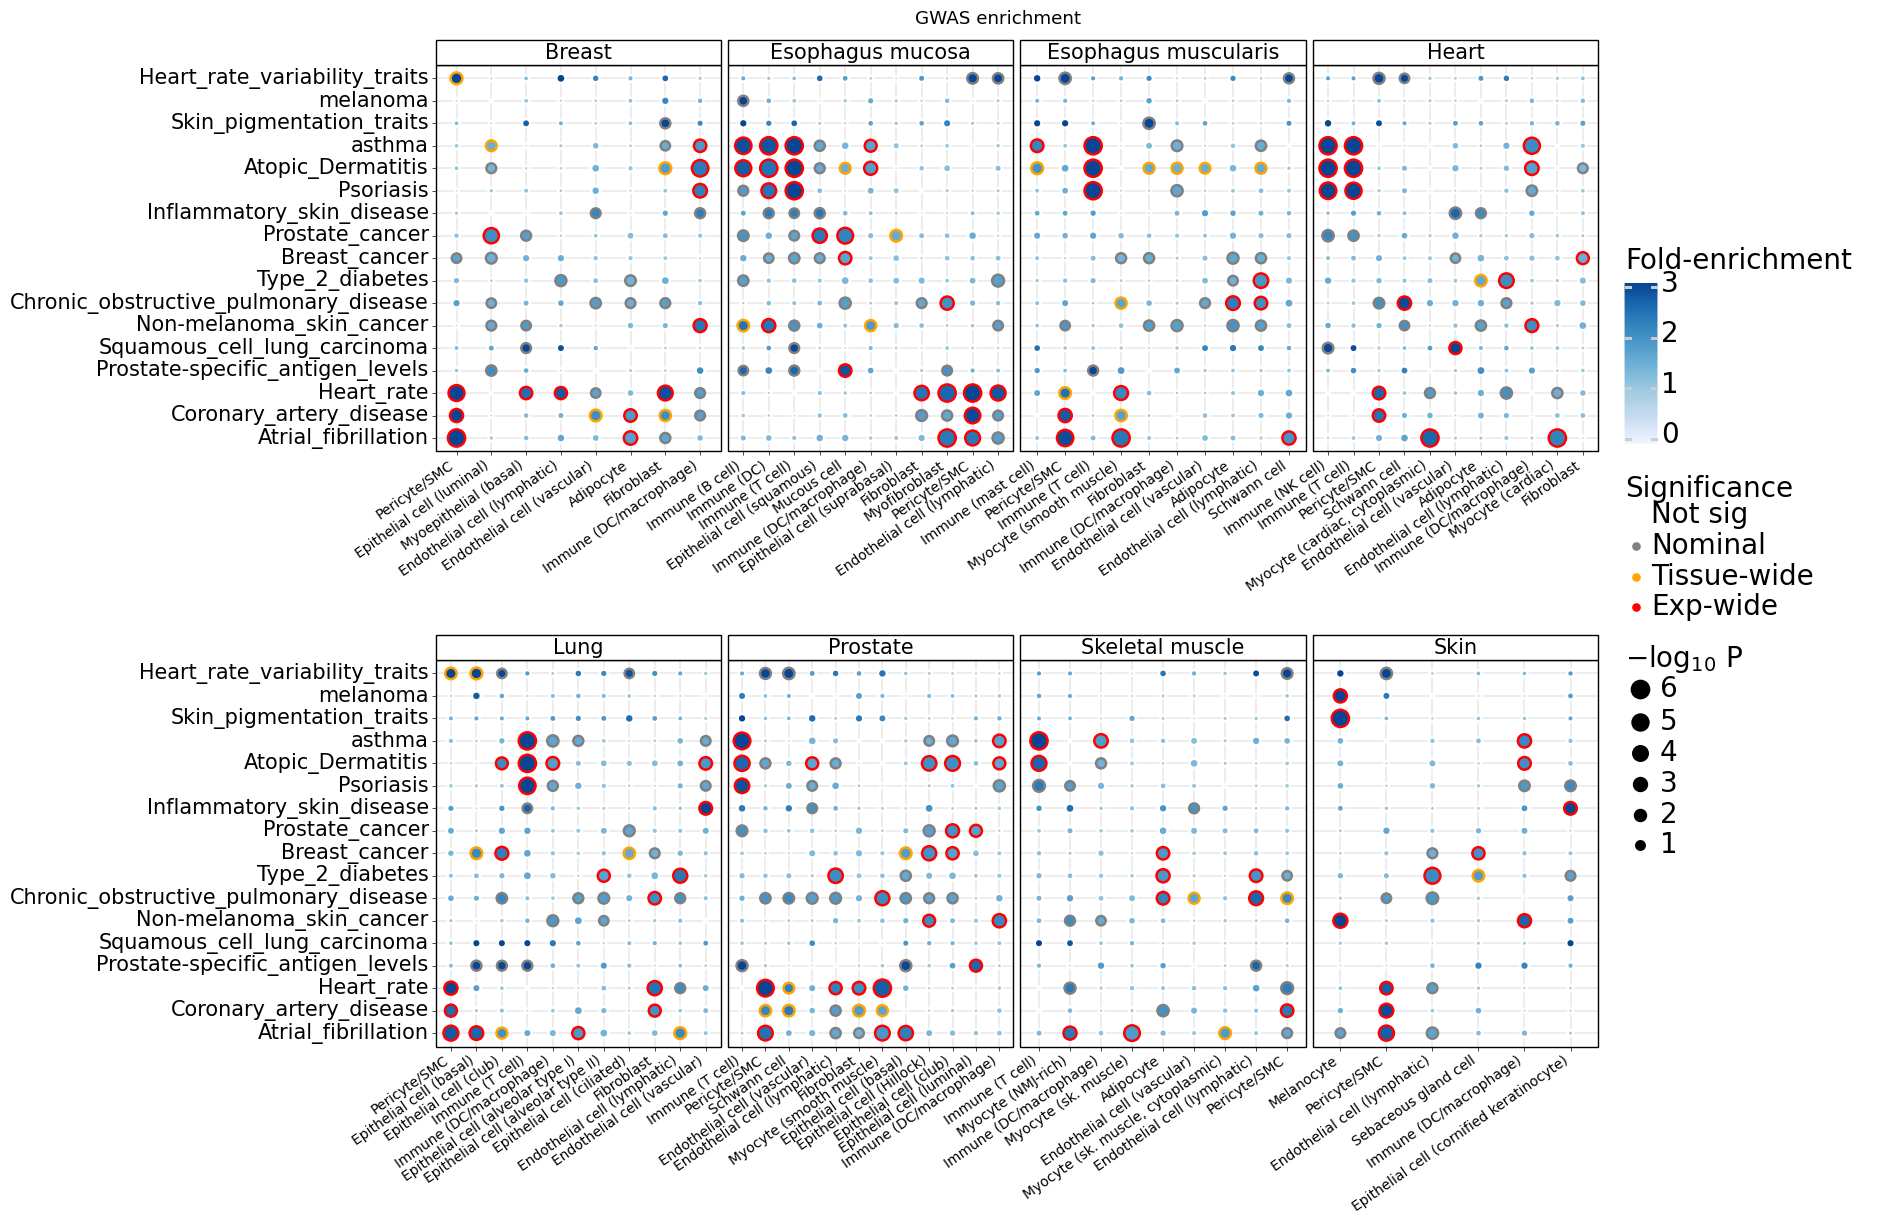

<ggplot: (8783044364685)>

In [10]:
## take negative log of p-value
df_sub['neglog_pval'] = -np.log10(np.clip(df_sub['Enrichment p-value'],1e-6,None))

## create an indicator of significance (not significant/nominal significant/experiment-wide significant)
df_sub['Significance'] = 'Not sig'
df_sub.loc[(df_sub['Enrichment p-value'] <0.05)&(df_sub['BH adj. Enrichment p-value (tissue-wide)'] >0.05), 'Significance'] = 'Nominal'
df_sub.loc[(df_sub['BH adj. Enrichment p-value (tissue-wide)'] <0.05)&(df_sub['BH adj. Enrichment P-value (Experiment-wide)'] >0.05), 'Significance'] = 'Tissue-wide'
df_sub.loc[(df_sub['BH adj. Enrichment P-value (Experiment-wide)'] <0.05), 'Significance'] = 'Exp-wide'

df_sub['Significance']=pd.Categorical(df_sub['Significance'],['Not sig','Nominal','Tissue-wide','Exp-wide'])
                
g = (
    ggplot(aes(x='celltypetissue', y='GWAS',), data=df_sub) +
    geom_point(aes(fill='Fold-enrichment', size='neglog_pval',color='Significance'), stroke=1)+
    facet_wrap('Tissue', nrow=2, scales='free_x') +
    scale_fill_distiller(type='seq', palette='Blues', direction=1, limits=[0, 3], name='Fold-enrichment') + 
    scale_color_manual(values={'Not sig':'white', 'Nominal':'gray','Tissue-wide':'orange','Exp-wide':'red'}, name='Significance') + 
    labs(y='', x='', title='GWAS enrichment') +
    guides(size = guide_legend(reverse=True)) +
    theme_linedraw() +
    scale_size(range = (0,6), name='$-\log_{10}$ P') +
    scale_x_discrete(drop=True, labels=lambda x: [i.split('|')[0] for i in x.keys()]) +
    theme(panel_spacing_y=1.8,#2.5
     strip_text_x = element_text(size=15, color='black', angle = 0),
     strip_text_y = element_text(size=15, color='black', angle = 0),
     strip_background=element_rect(color='black', fill='white'),
     figure_size=(15,15*(df_sub.GWAS.nunique()/20)),
     legend_key=element_blank(),
     legend_title = element_text(size = 20),
     legend_text = element_text(size = 20),
     axis_text_x = element_text(rotation=35, hjust=1.,size=10),
     axis_text_y = element_text(size=15),
     #panel_grid_major_x = element_line(color = '#E0E0E0'), ## change panel grid color to grey if saving to pdf 
     #panel_grid_major_y = element_line(color = '#E0E0E0')
    )
)


ggsave(g, 'Fig_5_B_bubblemap.png')
g

## Forest plot - Figure 5 (C)

In [11]:
def plot_CI(table,title):
    """
    plot 95% confidence interval of fold enrichment and p value from null permutations statistics and GWAS statistics
    """
    table=table.sort_values(by='Fold-enrichment')
    fig, ax = plt.subplots(figsize=(10,10))
    
    for lower,median,upper,p_val,bh_p_val,y in zip(table['Fold-enrichment lower 95% CI'],table['Fold-enrichment'],table['Fold-enrichment upper 95% CI'],table['Enrichment p-value'],table['BH adj. Enrichment p-value (tissue-wide)'],range(len(table))):
        ax.plot((lower,median,upper),(y,y,y),'k-')
        ax.plot(median,y,'bo-')
        ax.plot(np.array(median)[p_val<0.05],np.array(y)[p_val<0.05],color='orange',marker='o',linestyle='-')
        ax.plot(np.array(median)[bh_p_val<0.05],np.array(y)[bh_p_val<0.05],color='red',marker='o',linestyle='-')
    ax.set(yticks=np.arange(table.shape[0]),yticklabels=table['Cell type'])
    ax.axvline(x=1)

    l=[ax.scatter([],[], c=color,edgecolors='none') for color in ['red','orange','blue']]
    ax.legend(l,['BH adj. Enrichment p-value (tissue-wide)<0.05','p-value<0.05',r'p-value$\geq$0.05'],loc='lower right',fontsize=12)
    
    plt.title(title,fontsize=25)
    plt.xlabel('Fold Enrichment', fontsize=25)
    plt.yticks(size=20)
    plt.xticks(size=20)
    return fig

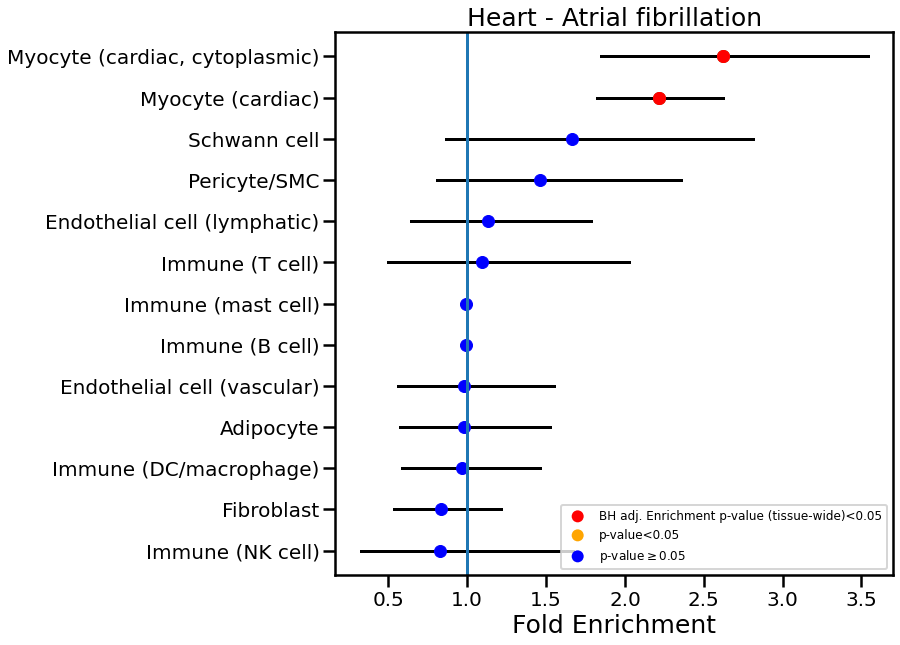

In [12]:
## Atrial fibrillation in Heart
GWAS_fp='Atrial_fibrillation'
Tissue_fp='Heart'
case_df=df_all.loc[(df_all['GWAS']==GWAS_fp)&(df_all['Tissue']==Tissue_fp),['Cell type','Fold-enrichment lower 95% CI','Fold-enrichment','Fold-enrichment upper 95% CI','Enrichment p-value','BH adj. Enrichment p-value (tissue-wide)']]
fig=plot_CI(case_df,title='Heart - Atrial fibrillation')
fig.savefig('Fig_5_C_forest_plot_afb_heart.png',bbox_inches='tight')

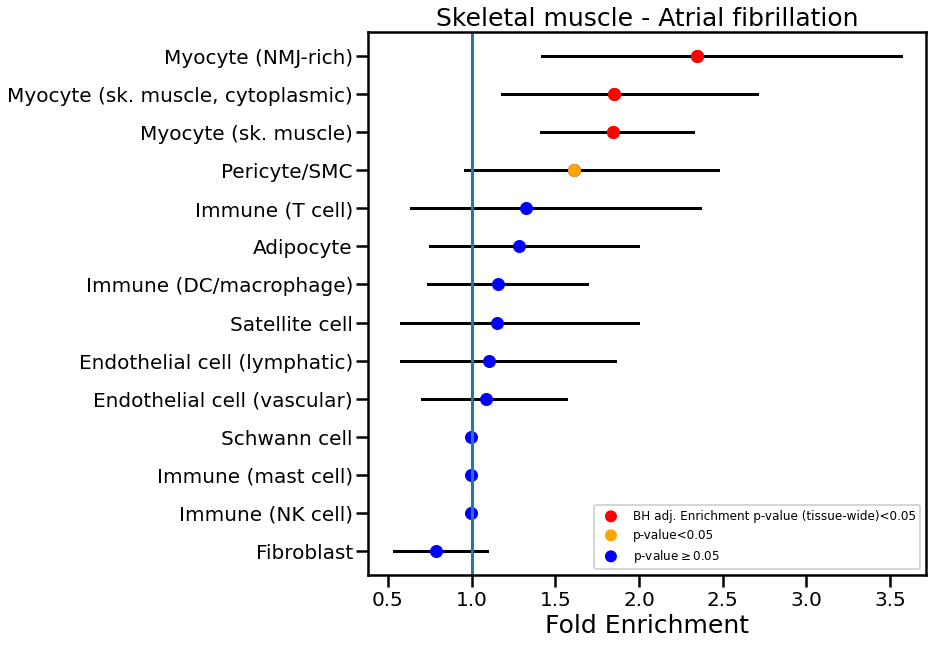

In [13]:
## Atrial fibrillation in Skeletal muscle
GWAS_fp='Atrial_fibrillation'
Tissue_fp='Skeletal muscle'
case_df=df_all.loc[(df_all['GWAS']==GWAS_fp)&(df_all['Tissue']==Tissue_fp),['Cell type','Fold-enrichment lower 95% CI','Fold-enrichment','Fold-enrichment upper 95% CI','Enrichment p-value','BH adj. Enrichment p-value (tissue-wide)']]
fig=plot_CI(case_df,title='Skeletal muscle - Atrial fibrillation')
fig.savefig('Fig_5_C_forest_plot_afb_Skeletal_muscle.png',bbox_inches='tight')

## Leading-edge genes plot - Figure 5 (D)

In [14]:
## read differential expression table
sc_df = pd.read_csv(sc_df, sep=',')

In [15]:
## Select the leading-edge genes in the target tissue, trait and cell type
GWAS_legp='Atrial_fibrillation'
Tissue_legp='Heart'
Cell_legp='Myocyte (cardiac, cytoplasmic)'
leading_genes=df_all.loc[(df_all['GWAS']==GWAS_legp)&(df_all['Tissue']==Tissue_legp)&(df_all['Cell type']==Cell_legp),'Leading edge genes']
leading_genes=leading_genes.str.split(r";|,").tolist()[0]

In [16]:
## Select other tissues and cell types to plot the log2FC for the same genes 
Tissue_list=['Heart','Esophagus muscularis','Prostate','Skeletal muscle']
Cell_list=['Myocyte (cardiac, cytoplasmic)','Myocyte (smooth muscle)','Myocyte (smooth muscle)','Myocyte (sk. muscle)']

In [17]:
# Extract rows from DGE table that correspond to cell types and cell list given above
plot_df=sc_df.loc[(sc_df['gene'].isin(leading_genes))&(sc_df['celltype'].isin(Cell_list)),:].copy()

# sort leading-edge genes from given trait and tissue based on log2FC
genes_order=plot_df.loc[(plot_df['celltype']==Cell_legp) & (plot_df['tissue']==Tissue_legp),:].sort_values(by='log2FC',ascending=False)['gene'].to_list()

# creating legend: tissue + celltype
plot_df['legend']=plot_df['tissue']+' '+plot_df['celltype']

# setting lower bound to -5; no upper bound
plot_df['log2FC']=np.clip(plot_df['log2FC'],-5, None)

# plot points for any tissue cell types if log2FC above 0 and fdr below 0.1
plot_df = plot_df.loc[(plot_df["pvals_fdr"] <= 0.1) & (plot_df["log2FC"] > 0.5)] 

# subset on tissue
plot_df = plot_df.loc[plot_df["tissue"].isin(Tissue_list)] 



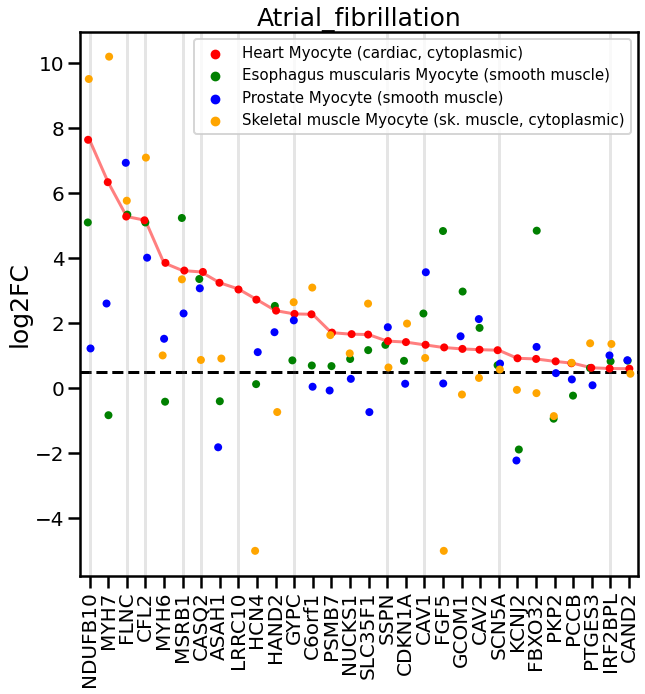

In [18]:
fig=plt.figure(figsize=(10,10))
plot_df['gene']=pd.Categorical(plot_df['gene'],genes_order)
sns.lineplot(data=plot_df.loc[plot_df['legend']=='Heart Myocyte (cardiac, cytoplasmic)',:], x="gene", y="log2FC",
             color='red',alpha=0.5, ci=None)
sns.stripplot(data=plot_df, x="gene", y="log2FC",hue="legend",size=8,\
              palette=sns.color_palette(["red","green","blue","orange"]),\
              hue_order = ['Heart Myocyte (cardiac, cytoplasmic)', 'Esophagus muscularis Myocyte (smooth muscle)','Prostate Myocyte (smooth muscle)','Skeletal muscle Myocyte (sk. muscle)'])


plt.xticks(rotation=90,size=20, style='italic')
plt.legend(loc='upper right',fontsize=15)
plt.xlabel('')
plt.ylabel('$Log_{2}(FC)$', fontsize=25)
plt.yticks(size=20)
plt.axhline(y=0.5,linestyle='--',color='black')
plt.title(GWAS_legp,position=(0.5, 0.92),size=25)

# adds vertical lines where log2FC >= 0.5 for all cell types tested
for v in range(len(genes_order)):
    if (plot_df.loc[(plot_df['gene']==genes_order[v]),'log2FC']>=0.5).all() and len(plot_df.loc[(plot_df["gene"]==genes_order[v])]["celltype"]) ==len(Cell_list): # and statement 
        plt.axvline(x=v,alpha=0.2,color="#737373", linewidth=3) # dark gray
    elif len(plot_df.loc[(plot_df['gene']==genes_order[v]),'log2FC']>=0.5) == 1:
        plt.axvline(x=v,alpha=0.2,color="#FF7F7F", linewidth=3) # light red
        
fig.savefig('Fig_6_D_leading_edge_genes.png',bbox_inches='tight')